In [1]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [2]:
# Define the VGG model
class VGG(nn.Module):
    def __init__(self):
        super(VGG, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(512 * 1 * 1, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 1000),
            nn.ReLU(inplace=True),
            nn.Linear(1000, 100)
        )
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [3]:
# Load CIFAR-10 data and apply transformations
transform = transforms.Compose(
    [
        transforms.Resize((32, 32)),  # CIFAR-10 images are 32x32
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ]
)

trainset = torchvision.datasets.CIFAR100(
    root="./data", train=True, download=True, transform=transform
)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)

testset = torchvision.datasets.CIFAR100(
    root="./data", train=False, download=True, transform=transform
)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False)

# Initialize the model, loss function, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = VGG().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)

# Training and validation loops
train_losses, val_losses = [], []
train_accs, val_accs = [], []

100%|██████████| 169001437/169001437 [00:20<00:00, 8441808.88it/s] 


Extracting ./data\cifar-100-python.tar.gz to ./data
Files already downloaded and verified


In [5]:
from tqdm import tqdm

train_accs, val_accs = [], []

for epoch in range(200):
    net.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for i, data in enumerate(tqdm(trainloader, 0)):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_losses.append(running_loss / len(trainloader))
    train_accs.append(100.0 * correct / total)

    # Validation
    net.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    val_losses.append(val_loss / len(testloader))
    val_accs.append(100.0 * correct / total)

    print(
        f"Epoch {epoch+1}, Train Loss: {train_losses[-1]}, Train Acc: {train_accs[-1]}, Val Loss: {val_losses[-1]}, Val Acc: {val_accs[-1]}"
    )

100%|██████████| 1563/1563 [00:22<00:00, 70.49it/s]


Epoch 1, Train Loss: 4.606572891303689, Train Acc: 0.89, Val Loss: 4.605370964866857, Val Acc: 1.0


100%|██████████| 1563/1563 [00:21<00:00, 72.58it/s]


Epoch 2, Train Loss: 4.606524741123368, Train Acc: 0.892, Val Loss: 4.6053588992109695, Val Acc: 1.0


100%|██████████| 1563/1563 [00:21<00:00, 73.44it/s]


Epoch 3, Train Loss: 4.606454806227144, Train Acc: 0.878, Val Loss: 4.605335613409171, Val Acc: 1.0


100%|██████████| 1563/1563 [00:21<00:00, 71.41it/s]


Epoch 4, Train Loss: 4.606393897068172, Train Acc: 0.956, Val Loss: 4.605298155032027, Val Acc: 1.0


100%|██████████| 1563/1563 [00:21<00:00, 71.17it/s]


Epoch 5, Train Loss: 4.60644067622726, Train Acc: 0.892, Val Loss: 4.6052924421267765, Val Acc: 1.0


100%|██████████| 1563/1563 [00:21<00:00, 72.63it/s]


Epoch 6, Train Loss: 4.606451546161966, Train Acc: 0.926, Val Loss: 4.605309637209859, Val Acc: 1.0


100%|██████████| 1563/1563 [00:21<00:00, 73.03it/s]


Epoch 7, Train Loss: 4.6064278046747695, Train Acc: 0.838, Val Loss: 4.605307781658234, Val Acc: 1.0


100%|██████████| 1563/1563 [00:21<00:00, 72.78it/s]


Epoch 8, Train Loss: 4.606428240326377, Train Acc: 0.896, Val Loss: 4.605289058563428, Val Acc: 1.0


100%|██████████| 1563/1563 [00:21<00:00, 72.85it/s]


Epoch 9, Train Loss: 4.606391756029672, Train Acc: 0.96, Val Loss: 4.605276511500057, Val Acc: 1.0


100%|██████████| 1563/1563 [00:21<00:00, 72.60it/s]


Epoch 10, Train Loss: 4.606397604988084, Train Acc: 0.91, Val Loss: 4.605310473579188, Val Acc: 1.0


100%|██████████| 1563/1563 [00:21<00:00, 72.87it/s]


Epoch 11, Train Loss: 4.606403277611321, Train Acc: 0.9, Val Loss: 4.605282353897826, Val Acc: 1.0


100%|██████████| 1563/1563 [00:21<00:00, 73.02it/s]


Epoch 12, Train Loss: 4.606460894061752, Train Acc: 0.914, Val Loss: 4.605272808014013, Val Acc: 1.0


100%|██████████| 1563/1563 [00:21<00:00, 72.74it/s]


Epoch 13, Train Loss: 4.606389550314603, Train Acc: 0.874, Val Loss: 4.605283193314038, Val Acc: 1.0


100%|██████████| 1563/1563 [00:21<00:00, 72.83it/s]


Epoch 14, Train Loss: 4.606428590251022, Train Acc: 0.776, Val Loss: 4.6053099038121035, Val Acc: 1.0


100%|██████████| 1563/1563 [00:21<00:00, 72.83it/s]


Epoch 15, Train Loss: 4.606386621564303, Train Acc: 0.89, Val Loss: 4.605323555370489, Val Acc: 1.0


100%|██████████| 1563/1563 [00:21<00:00, 72.90it/s]


Epoch 16, Train Loss: 4.606381501132528, Train Acc: 0.934, Val Loss: 4.605300181209089, Val Acc: 1.0


100%|██████████| 1563/1563 [00:21<00:00, 73.18it/s]


Epoch 17, Train Loss: 4.606413002892785, Train Acc: 0.896, Val Loss: 4.605292798612065, Val Acc: 1.0


100%|██████████| 1563/1563 [00:21<00:00, 72.38it/s]


Epoch 18, Train Loss: 4.606424590371316, Train Acc: 0.892, Val Loss: 4.605295336665437, Val Acc: 1.0


100%|██████████| 1563/1563 [00:21<00:00, 71.86it/s]


Epoch 19, Train Loss: 4.606425710923383, Train Acc: 0.894, Val Loss: 4.605290830325775, Val Acc: 1.0


100%|██████████| 1563/1563 [00:21<00:00, 72.84it/s]


Epoch 20, Train Loss: 4.606426095626938, Train Acc: 0.884, Val Loss: 4.60527970310979, Val Acc: 1.0


100%|██████████| 1563/1563 [00:21<00:00, 73.03it/s]


Epoch 21, Train Loss: 4.6063795681573305, Train Acc: 0.916, Val Loss: 4.605317982621848, Val Acc: 1.0


100%|██████████| 1563/1563 [00:21<00:00, 73.25it/s]


Epoch 22, Train Loss: 4.606429279117499, Train Acc: 0.914, Val Loss: 4.605298630345744, Val Acc: 1.0


100%|██████████| 1563/1563 [00:21<00:00, 72.78it/s]


Epoch 23, Train Loss: 4.606359335984164, Train Acc: 0.91, Val Loss: 4.6053112581515085, Val Acc: 1.0


100%|██████████| 1563/1563 [00:21<00:00, 72.77it/s]


Epoch 24, Train Loss: 4.6063252743130985, Train Acc: 0.974, Val Loss: 4.605310755415847, Val Acc: 1.0


100%|██████████| 1563/1563 [00:21<00:00, 72.80it/s]


Epoch 25, Train Loss: 4.606432715212772, Train Acc: 0.932, Val Loss: 4.605291078646724, Val Acc: 1.0


100%|██████████| 1563/1563 [00:21<00:00, 73.05it/s]


Epoch 26, Train Loss: 4.6063873467350795, Train Acc: 0.91, Val Loss: 4.605326501706156, Val Acc: 1.0


100%|██████████| 1563/1563 [00:21<00:00, 73.20it/s]


Epoch 27, Train Loss: 4.606392260628943, Train Acc: 0.86, Val Loss: 4.605294075255958, Val Acc: 1.0


100%|██████████| 1563/1563 [00:21<00:00, 71.91it/s]


Epoch 28, Train Loss: 4.6063677402772125, Train Acc: 0.914, Val Loss: 4.605288325788114, Val Acc: 1.0


100%|██████████| 1563/1563 [00:21<00:00, 72.10it/s]


Epoch 29, Train Loss: 4.606413314987739, Train Acc: 0.92, Val Loss: 4.605295525572171, Val Acc: 1.0


100%|██████████| 1563/1563 [00:21<00:00, 72.14it/s]


Epoch 30, Train Loss: 4.6063863613326355, Train Acc: 0.942, Val Loss: 4.605300458475424, Val Acc: 1.0


100%|██████████| 1563/1563 [00:21<00:00, 72.44it/s]


Epoch 31, Train Loss: 4.606402918839409, Train Acc: 0.896, Val Loss: 4.60528612289185, Val Acc: 1.0


100%|██████████| 1563/1563 [00:21<00:00, 73.30it/s]


Epoch 32, Train Loss: 4.606448033492075, Train Acc: 0.894, Val Loss: 4.605279445648193, Val Acc: 1.0


100%|██████████| 1563/1563 [00:21<00:00, 72.95it/s]


Epoch 33, Train Loss: 4.6064230332524065, Train Acc: 0.854, Val Loss: 4.605279217131983, Val Acc: 1.0


100%|██████████| 1563/1563 [00:21<00:00, 72.76it/s]


Epoch 34, Train Loss: 4.606399543454688, Train Acc: 0.926, Val Loss: 4.6052956550646895, Val Acc: 1.0


100%|██████████| 1563/1563 [00:21<00:00, 73.18it/s]


Epoch 35, Train Loss: 4.6063329528252135, Train Acc: 0.922, Val Loss: 4.6053336527400885, Val Acc: 1.0


100%|██████████| 1563/1563 [00:21<00:00, 73.16it/s]


Epoch 36, Train Loss: 4.606401298264243, Train Acc: 0.874, Val Loss: 4.605303506881665, Val Acc: 1.0


100%|██████████| 1563/1563 [00:21<00:00, 72.83it/s]


Epoch 37, Train Loss: 4.606495518602016, Train Acc: 0.85, Val Loss: 4.605253463355116, Val Acc: 1.0


100%|██████████| 1563/1563 [00:21<00:00, 72.78it/s]


Epoch 38, Train Loss: 4.60642850299867, Train Acc: 0.826, Val Loss: 4.605278930725, Val Acc: 1.0


100%|██████████| 1563/1563 [00:21<00:00, 72.88it/s]


Epoch 39, Train Loss: 4.606407059360145, Train Acc: 0.9, Val Loss: 4.605293497871667, Val Acc: 1.0


100%|██████████| 1563/1563 [00:21<00:00, 73.15it/s]


Epoch 40, Train Loss: 4.606411147407439, Train Acc: 0.84, Val Loss: 4.6052827865551835, Val Acc: 1.0


100%|██████████| 1563/1563 [00:21<00:00, 73.18it/s]


Epoch 41, Train Loss: 4.6064279453158, Train Acc: 0.866, Val Loss: 4.605264808423222, Val Acc: 1.0


100%|██████████| 1563/1563 [00:21<00:00, 72.96it/s]


Epoch 42, Train Loss: 4.606390226062718, Train Acc: 0.842, Val Loss: 4.605307003179679, Val Acc: 1.0


100%|██████████| 1563/1563 [00:21<00:00, 73.00it/s]


Epoch 43, Train Loss: 4.606409831300273, Train Acc: 0.838, Val Loss: 4.605302845708097, Val Acc: 1.0


100%|██████████| 1563/1563 [00:21<00:00, 71.09it/s]


Epoch 44, Train Loss: 4.606443057972426, Train Acc: 0.83, Val Loss: 4.605290566770414, Val Acc: 1.0


100%|██████████| 1563/1563 [00:21<00:00, 71.61it/s]


Epoch 45, Train Loss: 4.606448600022212, Train Acc: 0.894, Val Loss: 4.605273906415263, Val Acc: 1.0


100%|██████████| 1563/1563 [00:22<00:00, 70.90it/s]


Epoch 46, Train Loss: 4.60639012325138, Train Acc: 0.918, Val Loss: 4.605287000394096, Val Acc: 1.0


100%|██████████| 1563/1563 [00:21<00:00, 74.04it/s]


Epoch 47, Train Loss: 4.606454720195104, Train Acc: 0.842, Val Loss: 4.605259947121715, Val Acc: 1.0


100%|██████████| 1563/1563 [00:21<00:00, 73.35it/s]


Epoch 48, Train Loss: 4.606352353965481, Train Acc: 0.862, Val Loss: 4.6053286969852145, Val Acc: 1.0


100%|██████████| 1563/1563 [00:21<00:00, 73.13it/s]


Epoch 49, Train Loss: 4.606418713345714, Train Acc: 0.938, Val Loss: 4.605301494415576, Val Acc: 1.0


100%|██████████| 1563/1563 [00:21<00:00, 72.59it/s]


Epoch 50, Train Loss: 4.60641062114762, Train Acc: 0.86, Val Loss: 4.6052990325342735, Val Acc: 1.0


100%|██████████| 1563/1563 [00:21<00:00, 73.70it/s]


Epoch 51, Train Loss: 4.6064310253848655, Train Acc: 0.908, Val Loss: 4.60527454473721, Val Acc: 1.0


100%|██████████| 1563/1563 [00:20<00:00, 75.36it/s]


Epoch 52, Train Loss: 4.606423974418518, Train Acc: 0.916, Val Loss: 4.605281356043709, Val Acc: 1.0


100%|██████████| 1563/1563 [00:20<00:00, 74.51it/s]


Epoch 53, Train Loss: 4.606398471715125, Train Acc: 0.856, Val Loss: 4.6052987293694345, Val Acc: 1.0


100%|██████████| 1563/1563 [00:20<00:00, 75.22it/s]


Epoch 54, Train Loss: 4.606383429226476, Train Acc: 0.866, Val Loss: 4.605307802986413, Val Acc: 1.0


100%|██████████| 1563/1563 [00:20<00:00, 75.39it/s]


Epoch 55, Train Loss: 4.60638574507476, Train Acc: 0.908, Val Loss: 4.605312644483182, Val Acc: 1.0


100%|██████████| 1563/1563 [00:20<00:00, 74.95it/s]


Epoch 56, Train Loss: 4.606458546180261, Train Acc: 0.858, Val Loss: 4.605265734675593, Val Acc: 1.0


100%|██████████| 1563/1563 [00:21<00:00, 74.25it/s]


Epoch 57, Train Loss: 4.606399513862107, Train Acc: 0.946, Val Loss: 4.605287551879883, Val Acc: 1.0


100%|██████████| 1563/1563 [00:21<00:00, 73.64it/s]


Epoch 58, Train Loss: 4.606365127587883, Train Acc: 0.95, Val Loss: 4.605327498036832, Val Acc: 1.0


100%|██████████| 1563/1563 [00:21<00:00, 73.28it/s]


Epoch 59, Train Loss: 4.606389650075159, Train Acc: 0.906, Val Loss: 4.6052702105464265, Val Acc: 1.0


100%|██████████| 1563/1563 [00:22<00:00, 70.86it/s]


Epoch 60, Train Loss: 4.6063686237835535, Train Acc: 0.866, Val Loss: 4.60529860444724, Val Acc: 1.0


100%|██████████| 1563/1563 [00:22<00:00, 69.52it/s]


Epoch 61, Train Loss: 4.606433230184701, Train Acc: 0.866, Val Loss: 4.605289722783878, Val Acc: 1.0


100%|██████████| 1563/1563 [00:21<00:00, 72.10it/s]


Epoch 62, Train Loss: 4.606421690908519, Train Acc: 0.918, Val Loss: 4.605279882875875, Val Acc: 1.0


100%|██████████| 1563/1563 [00:21<00:00, 73.55it/s]


Epoch 63, Train Loss: 4.6063594360498, Train Acc: 0.91, Val Loss: 4.605331483359535, Val Acc: 1.0


100%|██████████| 1563/1563 [00:20<00:00, 74.96it/s]


Epoch 64, Train Loss: 4.606415501177807, Train Acc: 0.95, Val Loss: 4.605302836567449, Val Acc: 1.0


100%|██████████| 1563/1563 [00:21<00:00, 72.36it/s]


Epoch 65, Train Loss: 4.6064102846464134, Train Acc: 0.85, Val Loss: 4.605306002278678, Val Acc: 1.0


100%|██████████| 1563/1563 [00:21<00:00, 73.42it/s]


Epoch 66, Train Loss: 4.6063949352491385, Train Acc: 0.866, Val Loss: 4.605305942864463, Val Acc: 1.0


100%|██████████| 1563/1563 [00:21<00:00, 73.06it/s]


Epoch 67, Train Loss: 4.606423684899347, Train Acc: 0.918, Val Loss: 4.605306192708853, Val Acc: 1.0


100%|██████████| 1563/1563 [00:21<00:00, 73.08it/s]


Epoch 68, Train Loss: 4.606400591398155, Train Acc: 0.91, Val Loss: 4.605331120780482, Val Acc: 1.0


100%|██████████| 1563/1563 [00:21<00:00, 71.24it/s]


Epoch 69, Train Loss: 4.606377351459447, Train Acc: 0.9, Val Loss: 4.605326820105409, Val Acc: 1.0


100%|██████████| 1563/1563 [00:20<00:00, 75.16it/s]


Epoch 70, Train Loss: 4.60636713347676, Train Acc: 0.858, Val Loss: 4.605330330114395, Val Acc: 1.0


100%|██████████| 1563/1563 [00:21<00:00, 73.17it/s]


Epoch 71, Train Loss: 4.606441111878866, Train Acc: 0.852, Val Loss: 4.6052813834656545, Val Acc: 1.0


100%|██████████| 1563/1563 [00:21<00:00, 73.57it/s]


Epoch 72, Train Loss: 4.606378863426789, Train Acc: 0.896, Val Loss: 4.605329393197934, Val Acc: 1.0


100%|██████████| 1563/1563 [00:20<00:00, 74.78it/s]


Epoch 73, Train Loss: 4.606402181160427, Train Acc: 0.924, Val Loss: 4.605300482850486, Val Acc: 1.0


100%|██████████| 1563/1563 [00:21<00:00, 73.65it/s]


Epoch 74, Train Loss: 4.606364779798785, Train Acc: 0.942, Val Loss: 4.6053454944500904, Val Acc: 1.0


100%|██████████| 1563/1563 [00:21<00:00, 74.34it/s]


Epoch 75, Train Loss: 4.606387588967136, Train Acc: 0.894, Val Loss: 4.6053380234934655, Val Acc: 1.0


100%|██████████| 1563/1563 [00:21<00:00, 74.22it/s]


Epoch 76, Train Loss: 4.606403239171473, Train Acc: 0.904, Val Loss: 4.605300379256471, Val Acc: 1.0


100%|██████████| 1563/1563 [00:21<00:00, 74.20it/s]


Epoch 77, Train Loss: 4.606367546552583, Train Acc: 0.918, Val Loss: 4.6053299020273615, Val Acc: 1.0


100%|██████████| 1563/1563 [00:20<00:00, 74.87it/s]


Epoch 78, Train Loss: 4.606460726878923, Train Acc: 0.904, Val Loss: 4.605255882580059, Val Acc: 1.0


100%|██████████| 1563/1563 [00:21<00:00, 73.82it/s]


Epoch 79, Train Loss: 4.606390518022514, Train Acc: 0.914, Val Loss: 4.605311718230811, Val Acc: 1.0


100%|██████████| 1563/1563 [00:20<00:00, 74.66it/s]


Epoch 80, Train Loss: 4.6064563700577725, Train Acc: 0.822, Val Loss: 4.605286368165915, Val Acc: 1.0


100%|██████████| 1563/1563 [00:20<00:00, 74.95it/s]


Epoch 81, Train Loss: 4.606393392163824, Train Acc: 0.914, Val Loss: 4.605314573159995, Val Acc: 1.0


100%|██████████| 1563/1563 [00:21<00:00, 74.22it/s]


Epoch 82, Train Loss: 4.606391189804614, Train Acc: 0.876, Val Loss: 4.605299189448737, Val Acc: 1.0


100%|██████████| 1563/1563 [00:21<00:00, 74.29it/s]


Epoch 83, Train Loss: 4.606433416587453, Train Acc: 0.856, Val Loss: 4.605263572912246, Val Acc: 1.0


100%|██████████| 1563/1563 [00:21<00:00, 74.20it/s]


Epoch 84, Train Loss: 4.606423386227833, Train Acc: 0.888, Val Loss: 4.605308960801877, Val Acc: 1.0


100%|██████████| 1563/1563 [00:21<00:00, 74.22it/s]


Epoch 85, Train Loss: 4.606367266490836, Train Acc: 0.85, Val Loss: 4.605326973972991, Val Acc: 1.0


100%|██████████| 1563/1563 [00:21<00:00, 73.98it/s]


Epoch 86, Train Loss: 4.606422989931308, Train Acc: 0.93, Val Loss: 4.605286096993346, Val Acc: 1.0


100%|██████████| 1563/1563 [00:21<00:00, 74.13it/s]


Epoch 87, Train Loss: 4.606453245142219, Train Acc: 0.874, Val Loss: 4.605278165957418, Val Acc: 1.0


100%|██████████| 1563/1563 [00:21<00:00, 73.90it/s]


Epoch 88, Train Loss: 4.60638517579892, Train Acc: 0.88, Val Loss: 4.605304264032041, Val Acc: 1.0


100%|██████████| 1563/1563 [00:20<00:00, 75.11it/s]


Epoch 89, Train Loss: 4.606418735616419, Train Acc: 0.88, Val Loss: 4.605299169643999, Val Acc: 1.0


100%|██████████| 1563/1563 [00:20<00:00, 74.74it/s]


Epoch 90, Train Loss: 4.60642197036011, Train Acc: 0.926, Val Loss: 4.605293407988625, Val Acc: 1.0


100%|██████████| 1563/1563 [00:20<00:00, 74.87it/s]


Epoch 91, Train Loss: 4.606423495445813, Train Acc: 0.884, Val Loss: 4.605276404859159, Val Acc: 1.0


100%|██████████| 1563/1563 [00:20<00:00, 74.92it/s]


Epoch 92, Train Loss: 4.606434809879393, Train Acc: 0.94, Val Loss: 4.605324876194183, Val Acc: 1.0


100%|██████████| 1563/1563 [00:20<00:00, 75.46it/s]


Epoch 93, Train Loss: 4.606448726324568, Train Acc: 0.888, Val Loss: 4.605299588590384, Val Acc: 1.0


100%|██████████| 1563/1563 [00:21<00:00, 74.11it/s]


Epoch 94, Train Loss: 4.60642573624487, Train Acc: 0.878, Val Loss: 4.6052808944409644, Val Acc: 1.0


100%|██████████| 1563/1563 [00:21<00:00, 74.33it/s]


Epoch 95, Train Loss: 4.606411070527743, Train Acc: 0.866, Val Loss: 4.605264422992548, Val Acc: 1.0


100%|██████████| 1563/1563 [00:20<00:00, 74.80it/s]


Epoch 96, Train Loss: 4.606405122724009, Train Acc: 0.868, Val Loss: 4.605288409577391, Val Acc: 1.0


100%|██████████| 1563/1563 [00:20<00:00, 74.91it/s]


Epoch 97, Train Loss: 4.606404386570419, Train Acc: 0.858, Val Loss: 4.605309906858986, Val Acc: 1.0


100%|██████████| 1563/1563 [00:20<00:00, 75.75it/s]


Epoch 98, Train Loss: 4.606415416976236, Train Acc: 0.924, Val Loss: 4.605286688088609, Val Acc: 1.0


100%|██████████| 1563/1563 [00:20<00:00, 75.68it/s]


Epoch 99, Train Loss: 4.606362841942336, Train Acc: 0.948, Val Loss: 4.605318424419854, Val Acc: 1.0


100%|██████████| 1563/1563 [00:21<00:00, 74.33it/s]


Epoch 100, Train Loss: 4.606400142933265, Train Acc: 0.79, Val Loss: 4.6053044453215675, Val Acc: 1.0


100%|██████████| 1563/1563 [00:21<00:00, 73.12it/s]


Epoch 101, Train Loss: 4.606436264186964, Train Acc: 0.826, Val Loss: 4.605309876390159, Val Acc: 1.0


100%|██████████| 1563/1563 [00:21<00:00, 74.06it/s]


Epoch 102, Train Loss: 4.606442908484129, Train Acc: 0.842, Val Loss: 4.605267757805772, Val Acc: 1.0


100%|██████████| 1563/1563 [00:20<00:00, 75.23it/s]


Epoch 103, Train Loss: 4.606361513937122, Train Acc: 0.912, Val Loss: 4.605292969237501, Val Acc: 1.0


100%|██████████| 1563/1563 [00:20<00:00, 74.91it/s]


Epoch 104, Train Loss: 4.60640706027538, Train Acc: 0.882, Val Loss: 4.605305385284911, Val Acc: 1.0


100%|██████████| 1563/1563 [00:20<00:00, 74.61it/s]


Epoch 105, Train Loss: 4.606387865673024, Train Acc: 0.884, Val Loss: 4.605347624221168, Val Acc: 1.0


100%|██████████| 1563/1563 [00:20<00:00, 74.74it/s]


Epoch 106, Train Loss: 4.606461820279034, Train Acc: 0.928, Val Loss: 4.605292634080393, Val Acc: 1.0


100%|██████████| 1563/1563 [00:20<00:00, 74.87it/s]


Epoch 107, Train Loss: 4.606411624549676, Train Acc: 0.834, Val Loss: 4.6052993829257955, Val Acc: 1.0


100%|██████████| 1563/1563 [00:20<00:00, 75.64it/s]


Epoch 108, Train Loss: 4.606383492377654, Train Acc: 0.88, Val Loss: 4.605323372557521, Val Acc: 1.0


100%|██████████| 1563/1563 [00:20<00:00, 75.75it/s]


Epoch 109, Train Loss: 4.606451048884572, Train Acc: 0.9, Val Loss: 4.605274293369378, Val Acc: 1.0


100%|██████████| 1563/1563 [00:21<00:00, 74.31it/s]


Epoch 110, Train Loss: 4.6064080307289945, Train Acc: 0.858, Val Loss: 4.605302668988895, Val Acc: 1.0


100%|██████████| 1563/1563 [00:21<00:00, 73.50it/s]


Epoch 111, Train Loss: 4.606387791233954, Train Acc: 0.888, Val Loss: 4.605314260854508, Val Acc: 1.0


100%|██████████| 1563/1563 [00:20<00:00, 74.78it/s]


Epoch 112, Train Loss: 4.606452065404988, Train Acc: 0.838, Val Loss: 4.605300848476422, Val Acc: 1.0


100%|██████████| 1563/1563 [00:20<00:00, 74.78it/s]


Epoch 113, Train Loss: 4.6063872448389755, Train Acc: 0.856, Val Loss: 4.605305997708354, Val Acc: 1.0


100%|██████████| 1563/1563 [00:20<00:00, 75.08it/s]


Epoch 114, Train Loss: 4.606429633923394, Train Acc: 0.854, Val Loss: 4.605329249994442, Val Acc: 1.0


100%|██████████| 1563/1563 [00:20<00:00, 74.99it/s]


Epoch 115, Train Loss: 4.606423885335697, Train Acc: 0.956, Val Loss: 4.60527208590279, Val Acc: 1.0


100%|██████████| 1563/1563 [00:20<00:00, 75.48it/s]


Epoch 116, Train Loss: 4.6063860782201065, Train Acc: 0.838, Val Loss: 4.605307246930302, Val Acc: 1.0


100%|██████████| 1563/1563 [00:20<00:00, 75.45it/s]


Epoch 117, Train Loss: 4.606418312167938, Train Acc: 0.844, Val Loss: 4.6052809751833585, Val Acc: 1.0


100%|██████████| 1563/1563 [00:20<00:00, 75.26it/s]


Epoch 118, Train Loss: 4.606462662294746, Train Acc: 0.896, Val Loss: 4.605274110556411, Val Acc: 1.0


100%|██████████| 1563/1563 [00:20<00:00, 75.32it/s]


Epoch 119, Train Loss: 4.606381090802408, Train Acc: 0.894, Val Loss: 4.605284599450449, Val Acc: 1.0


100%|██████████| 1563/1563 [00:20<00:00, 75.19it/s]


Epoch 120, Train Loss: 4.606351704759165, Train Acc: 0.898, Val Loss: 4.605329895933596, Val Acc: 1.0


100%|██████████| 1563/1563 [00:20<00:00, 75.60it/s]


Epoch 121, Train Loss: 4.606413591693626, Train Acc: 0.806, Val Loss: 4.605312495185925, Val Acc: 1.0


100%|██████████| 1563/1563 [00:20<00:00, 75.06it/s]


Epoch 122, Train Loss: 4.60640973581081, Train Acc: 0.848, Val Loss: 4.605293266308574, Val Acc: 1.0


100%|██████████| 1563/1563 [00:20<00:00, 75.03it/s]


Epoch 123, Train Loss: 4.6064372944358976, Train Acc: 0.878, Val Loss: 4.605285621679629, Val Acc: 1.0


100%|██████████| 1563/1563 [00:20<00:00, 74.44it/s]


Epoch 124, Train Loss: 4.606404304199317, Train Acc: 0.886, Val Loss: 4.605291639273159, Val Acc: 1.0


100%|██████████| 1563/1563 [00:21<00:00, 73.79it/s]


Epoch 125, Train Loss: 4.60639443034479, Train Acc: 0.97, Val Loss: 4.60527582899831, Val Acc: 1.0


100%|██████████| 1563/1563 [00:20<00:00, 74.65it/s]


Epoch 126, Train Loss: 4.606412869573631, Train Acc: 0.824, Val Loss: 4.60530279391109, Val Acc: 1.0


100%|██████████| 1563/1563 [00:20<00:00, 74.69it/s]


Epoch 127, Train Loss: 4.6064214386088835, Train Acc: 0.87, Val Loss: 4.6052898690342525, Val Acc: 1.0


100%|██████████| 1563/1563 [00:21<00:00, 73.89it/s]


Epoch 128, Train Loss: 4.60638032109022, Train Acc: 0.946, Val Loss: 4.60533065156053, Val Acc: 1.0


100%|██████████| 1563/1563 [00:20<00:00, 75.04it/s]


Epoch 129, Train Loss: 4.606399958971137, Train Acc: 0.88, Val Loss: 4.605307595798383, Val Acc: 1.0


100%|██████████| 1563/1563 [00:20<00:00, 74.86it/s]


Epoch 130, Train Loss: 4.6064179064139905, Train Acc: 0.964, Val Loss: 4.605278747912032, Val Acc: 1.0


100%|██████████| 1563/1563 [00:21<00:00, 72.29it/s]


Epoch 131, Train Loss: 4.606413636235038, Train Acc: 0.862, Val Loss: 4.605306998609354, Val Acc: 1.0


100%|██████████| 1563/1563 [00:20<00:00, 75.02it/s]


Epoch 132, Train Loss: 4.606441511531251, Train Acc: 0.892, Val Loss: 4.605277704354673, Val Acc: 1.0


100%|██████████| 1563/1563 [00:20<00:00, 76.70it/s]


Epoch 133, Train Loss: 4.606435672335341, Train Acc: 0.878, Val Loss: 4.605276465796815, Val Acc: 1.0


100%|██████████| 1563/1563 [00:20<00:00, 76.90it/s]


Epoch 134, Train Loss: 4.60637809066382, Train Acc: 0.868, Val Loss: 4.605320622745794, Val Acc: 1.0


100%|██████████| 1563/1563 [00:20<00:00, 76.75it/s]


Epoch 135, Train Loss: 4.606430576309819, Train Acc: 0.924, Val Loss: 4.605305664074687, Val Acc: 1.0


100%|██████████| 1563/1563 [00:20<00:00, 76.78it/s]


Epoch 136, Train Loss: 4.606418274643325, Train Acc: 0.828, Val Loss: 4.605277229040956, Val Acc: 1.0


100%|██████████| 1563/1563 [00:20<00:00, 76.61it/s]


Epoch 137, Train Loss: 4.606442115280923, Train Acc: 0.928, Val Loss: 4.6052710743377006, Val Acc: 1.0


100%|██████████| 1563/1563 [00:20<00:00, 76.77it/s]


Epoch 138, Train Loss: 4.606434503580925, Train Acc: 0.81, Val Loss: 4.605278542247444, Val Acc: 1.0


100%|██████████| 1563/1563 [00:20<00:00, 76.15it/s]


Epoch 139, Train Loss: 4.6064039548848275, Train Acc: 0.906, Val Loss: 4.605295580416061, Val Acc: 1.0


100%|██████████| 1563/1563 [00:20<00:00, 77.15it/s]


Epoch 140, Train Loss: 4.606435534134937, Train Acc: 0.912, Val Loss: 4.605285228631748, Val Acc: 1.0


100%|██████████| 1563/1563 [00:20<00:00, 76.66it/s]


Epoch 141, Train Loss: 4.606443519860754, Train Acc: 0.854, Val Loss: 4.605276621187838, Val Acc: 1.0


100%|██████████| 1563/1563 [00:20<00:00, 76.69it/s]


Epoch 142, Train Loss: 4.606380286616388, Train Acc: 0.866, Val Loss: 4.605317030470973, Val Acc: 1.0


100%|██████████| 1563/1563 [00:20<00:00, 76.46it/s]


Epoch 143, Train Loss: 4.6064396267584025, Train Acc: 0.898, Val Loss: 4.605276383530979, Val Acc: 1.0


100%|██████████| 1563/1563 [00:20<00:00, 77.55it/s]


Epoch 144, Train Loss: 4.606372319500338, Train Acc: 0.852, Val Loss: 4.605302091604605, Val Acc: 1.0


100%|██████████| 1563/1563 [00:20<00:00, 76.73it/s]


Epoch 145, Train Loss: 4.6064283208670105, Train Acc: 0.858, Val Loss: 4.60532220712485, Val Acc: 1.0


100%|██████████| 1563/1563 [00:20<00:00, 77.04it/s]


Epoch 146, Train Loss: 4.606430428651992, Train Acc: 0.886, Val Loss: 4.605273889657408, Val Acc: 1.0


100%|██████████| 1563/1563 [00:20<00:00, 77.60it/s]


Epoch 147, Train Loss: 4.6064351601091165, Train Acc: 0.846, Val Loss: 4.605276156538211, Val Acc: 1.0


100%|██████████| 1563/1563 [00:20<00:00, 77.26it/s]


Epoch 148, Train Loss: 4.606357731578141, Train Acc: 0.89, Val Loss: 4.605284715231996, Val Acc: 1.0


100%|██████████| 1563/1563 [00:20<00:00, 76.62it/s]


Epoch 149, Train Loss: 4.606447969730741, Train Acc: 0.924, Val Loss: 4.605270297382586, Val Acc: 1.0


100%|██████████| 1563/1563 [00:20<00:00, 78.08it/s]


Epoch 150, Train Loss: 4.606423795642718, Train Acc: 0.98, Val Loss: 4.605313039054505, Val Acc: 1.0


100%|██████████| 1563/1563 [00:20<00:00, 77.88it/s]


Epoch 151, Train Loss: 4.606387585306198, Train Acc: 0.894, Val Loss: 4.6052986821427515, Val Acc: 1.0


100%|██████████| 1563/1563 [00:20<00:00, 77.56it/s]


Epoch 152, Train Loss: 4.606430349636749, Train Acc: 0.85, Val Loss: 4.605315409529323, Val Acc: 1.0


100%|██████████| 1563/1563 [00:21<00:00, 73.68it/s]


Epoch 153, Train Loss: 4.606419065100828, Train Acc: 0.868, Val Loss: 4.60531504695027, Val Acc: 1.0


100%|██████████| 1563/1563 [00:20<00:00, 74.62it/s]


Epoch 154, Train Loss: 4.60641489498751, Train Acc: 0.86, Val Loss: 4.605304029422065, Val Acc: 1.0


100%|██████████| 1563/1563 [00:24<00:00, 64.98it/s]


Epoch 155, Train Loss: 4.606384918007878, Train Acc: 0.894, Val Loss: 4.6052840951913465, Val Acc: 1.0


100%|██████████| 1563/1563 [00:24<00:00, 64.28it/s]


Epoch 156, Train Loss: 4.606381061819984, Train Acc: 0.856, Val Loss: 4.60529032301979, Val Acc: 1.0


100%|██████████| 1563/1563 [00:24<00:00, 63.46it/s]


Epoch 157, Train Loss: 4.606394293059619, Train Acc: 0.836, Val Loss: 4.605289981768916, Val Acc: 1.0


100%|██████████| 1563/1563 [00:21<00:00, 72.33it/s]


Epoch 158, Train Loss: 4.606431110196593, Train Acc: 0.928, Val Loss: 4.605296154753469, Val Acc: 1.0


100%|██████████| 1563/1563 [00:21<00:00, 73.79it/s]


Epoch 159, Train Loss: 4.606386194149805, Train Acc: 0.876, Val Loss: 4.6052852651943414, Val Acc: 1.0


100%|██████████| 1563/1563 [00:21<00:00, 73.74it/s]


Epoch 160, Train Loss: 4.606385612060683, Train Acc: 0.89, Val Loss: 4.605296194362945, Val Acc: 1.0


100%|██████████| 1563/1563 [00:20<00:00, 74.79it/s]


Epoch 161, Train Loss: 4.606428555472112, Train Acc: 0.836, Val Loss: 4.605269061871611, Val Acc: 1.0


100%|██████████| 1563/1563 [00:20<00:00, 75.92it/s]


Epoch 162, Train Loss: 4.606357119286281, Train Acc: 0.876, Val Loss: 4.60531643937571, Val Acc: 1.0


100%|██████████| 1563/1563 [00:20<00:00, 76.19it/s]


Epoch 163, Train Loss: 4.606462107052501, Train Acc: 0.874, Val Loss: 4.605278622989838, Val Acc: 1.0


100%|██████████| 1563/1563 [00:20<00:00, 75.89it/s]


Epoch 164, Train Loss: 4.6063655510363635, Train Acc: 0.894, Val Loss: 4.605292189235504, Val Acc: 1.0


100%|██████████| 1563/1563 [00:20<00:00, 75.88it/s]


Epoch 165, Train Loss: 4.606410438100726, Train Acc: 0.892, Val Loss: 4.6053309181627755, Val Acc: 1.0


100%|██████████| 1563/1563 [00:20<00:00, 75.90it/s]


Epoch 166, Train Loss: 4.6064625469752025, Train Acc: 0.928, Val Loss: 4.605281452020517, Val Acc: 1.0


100%|██████████| 1563/1563 [00:20<00:00, 75.91it/s]


Epoch 167, Train Loss: 4.606378433266589, Train Acc: 0.962, Val Loss: 4.605316878126833, Val Acc: 1.0


100%|██████████| 1563/1563 [00:20<00:00, 76.15it/s]


Epoch 168, Train Loss: 4.606393307657175, Train Acc: 0.894, Val Loss: 4.605283371556681, Val Acc: 1.0


100%|██████████| 1563/1563 [00:20<00:00, 75.98it/s]


Epoch 169, Train Loss: 4.60630744524057, Train Acc: 0.892, Val Loss: 4.605358067411965, Val Acc: 1.0


100%|██████████| 1563/1563 [00:20<00:00, 75.92it/s]


Epoch 170, Train Loss: 4.60643903978803, Train Acc: 0.886, Val Loss: 4.605291963766177, Val Acc: 1.0


100%|██████████| 1563/1563 [00:20<00:00, 75.60it/s]


Epoch 171, Train Loss: 4.606390109827941, Train Acc: 0.932, Val Loss: 4.605294448499101, Val Acc: 1.0


100%|██████████| 1563/1563 [00:21<00:00, 74.03it/s]


Epoch 172, Train Loss: 4.606438549527432, Train Acc: 0.866, Val Loss: 4.60529043270757, Val Acc: 1.0


100%|██████████| 1563/1563 [00:20<00:00, 75.68it/s]


Epoch 173, Train Loss: 4.606361650612136, Train Acc: 0.878, Val Loss: 4.605341180064046, Val Acc: 1.0


100%|██████████| 1563/1563 [00:20<00:00, 76.00it/s]


Epoch 174, Train Loss: 4.606391812774209, Train Acc: 0.9, Val Loss: 4.605326436198177, Val Acc: 1.0


100%|██████████| 1563/1563 [00:20<00:00, 75.96it/s]


Epoch 175, Train Loss: 4.606345874410521, Train Acc: 0.918, Val Loss: 4.605346076404706, Val Acc: 1.0


100%|██████████| 1563/1563 [00:20<00:00, 75.23it/s]


Epoch 176, Train Loss: 4.6064240119431314, Train Acc: 0.888, Val Loss: 4.605283339564412, Val Acc: 1.0


100%|██████████| 1563/1563 [00:20<00:00, 76.16it/s]


Epoch 177, Train Loss: 4.60642448878029, Train Acc: 0.964, Val Loss: 4.605284369410798, Val Acc: 1.0


100%|██████████| 1563/1563 [00:20<00:00, 76.11it/s]


Epoch 178, Train Loss: 4.6064806381098675, Train Acc: 0.854, Val Loss: 4.605278114160409, Val Acc: 1.0


100%|██████████| 1563/1563 [00:20<00:00, 76.01it/s]


Epoch 179, Train Loss: 4.6063463832808855, Train Acc: 0.832, Val Loss: 4.605333476020886, Val Acc: 1.0


100%|██████████| 1563/1563 [00:20<00:00, 75.82it/s]


Epoch 180, Train Loss: 4.606381254629378, Train Acc: 0.836, Val Loss: 4.60532011696325, Val Acc: 1.0


100%|██████████| 1563/1563 [00:20<00:00, 76.20it/s]


Epoch 181, Train Loss: 4.606432621858857, Train Acc: 0.904, Val Loss: 4.6052777256828525, Val Acc: 1.0


100%|██████████| 1563/1563 [00:20<00:00, 75.96it/s]


Epoch 182, Train Loss: 4.606400700005978, Train Acc: 0.88, Val Loss: 4.605311274909364, Val Acc: 1.0


100%|██████████| 1563/1563 [00:20<00:00, 76.14it/s]


Epoch 183, Train Loss: 4.60638441127306, Train Acc: 0.856, Val Loss: 4.605282987649448, Val Acc: 1.0


100%|██████████| 1563/1563 [00:20<00:00, 76.15it/s]


Epoch 184, Train Loss: 4.606414797667578, Train Acc: 0.884, Val Loss: 4.60529457799162, Val Acc: 1.0


100%|██████████| 1563/1563 [00:20<00:00, 75.90it/s]


Epoch 185, Train Loss: 4.606405747524073, Train Acc: 0.934, Val Loss: 4.60529577541656, Val Acc: 1.0


100%|██████████| 1563/1563 [00:20<00:00, 76.12it/s]


Epoch 186, Train Loss: 4.60639875726828, Train Acc: 0.906, Val Loss: 4.605308330097137, Val Acc: 1.0


100%|██████████| 1563/1563 [00:20<00:00, 75.26it/s]


Epoch 187, Train Loss: 4.606384218463666, Train Acc: 0.944, Val Loss: 4.605332264884973, Val Acc: 1.0


100%|██████████| 1563/1563 [00:21<00:00, 73.86it/s]


Epoch 188, Train Loss: 4.606409456664297, Train Acc: 0.912, Val Loss: 4.605298279954222, Val Acc: 1.0


100%|██████████| 1563/1563 [00:20<00:00, 75.34it/s]


Epoch 189, Train Loss: 4.606421407490911, Train Acc: 0.958, Val Loss: 4.605294433264687, Val Acc: 1.0


100%|██████████| 1563/1563 [00:20<00:00, 75.00it/s]


Epoch 190, Train Loss: 4.606324115321184, Train Acc: 0.882, Val Loss: 4.605351496809207, Val Acc: 1.0


100%|██████████| 1563/1563 [00:20<00:00, 75.42it/s]


Epoch 191, Train Loss: 4.606445289008982, Train Acc: 0.894, Val Loss: 4.605279119631734, Val Acc: 1.0


100%|██████████| 1563/1563 [00:20<00:00, 75.92it/s]


Epoch 192, Train Loss: 4.606369617423108, Train Acc: 0.958, Val Loss: 4.605339659669529, Val Acc: 1.0


100%|██████████| 1563/1563 [00:20<00:00, 75.92it/s]


Epoch 193, Train Loss: 4.60638790106209, Train Acc: 0.904, Val Loss: 4.605266018035693, Val Acc: 1.0


100%|██████████| 1563/1563 [00:20<00:00, 76.20it/s]


Epoch 194, Train Loss: 4.606367221644347, Train Acc: 0.91, Val Loss: 4.605298557220556, Val Acc: 1.0


100%|██████████| 1563/1563 [00:20<00:00, 76.03it/s]


Epoch 195, Train Loss: 4.606370925293164, Train Acc: 0.924, Val Loss: 4.605302289651987, Val Acc: 1.0


100%|██████████| 1563/1563 [00:20<00:00, 76.08it/s]


Epoch 196, Train Loss: 4.606441817219564, Train Acc: 0.862, Val Loss: 4.60527222758284, Val Acc: 1.0


100%|██████████| 1563/1563 [00:20<00:00, 76.16it/s]


Epoch 197, Train Loss: 4.606383613493682, Train Acc: 0.95, Val Loss: 4.605299743981407, Val Acc: 1.0


100%|██████████| 1563/1563 [00:20<00:00, 75.86it/s]


Epoch 198, Train Loss: 4.6064126599849375, Train Acc: 0.938, Val Loss: 4.605302221097124, Val Acc: 1.0


100%|██████████| 1563/1563 [00:20<00:00, 76.33it/s]


Epoch 199, Train Loss: 4.60637540017956, Train Acc: 0.914, Val Loss: 4.605290373293355, Val Acc: 1.0


100%|██████████| 1563/1563 [00:20<00:00, 76.01it/s]


Epoch 200, Train Loss: 4.606322717453072, Train Acc: 0.868, Val Loss: 4.605340227913171, Val Acc: 1.0


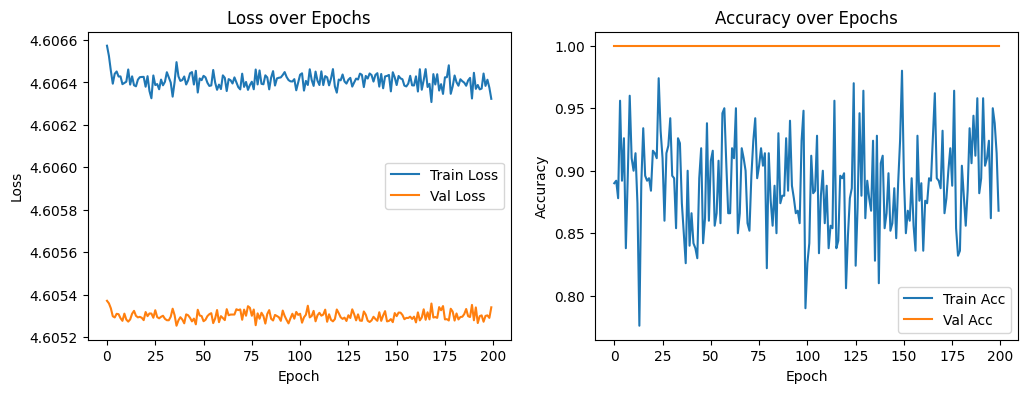

In [6]:
# Plotting training and validation accuracy and loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss over Epochs")

plt.subplot(1, 2, 2)
plt.plot(train_accs, label="Train Acc")
plt.plot(val_accs, label="Val Acc")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy over Epochs")

plt.show()